<a href="https://colab.research.google.com/github/JHyunjun/SNU/blob/main/CNN_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Training Convolutional Neural Networks

Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. 

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **TensorFlow**. <br>
In this notebook, you will learn how to train convolutional neural networks (CNNs) for classifying images in the CIFAR-10 dataset. <br>
There are **3 sections**, and in each section, you need to follow the instructions to complete the skeleton codes and explain them.

1. [Training a simple CNN model](#1)
2. [Training a CNN model with Inception modules](#2)
3. [Design a better model on CIFAR-10](#3)

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Some helpful tutorials and references for assignment #2:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016. [[pdf]](https://arxiv.org/pdf/1602.07360.pdf)
- [4] Simonyan et al., "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014. [[pdf]](https://arxiv.org/pdf/1312.6034.pdf)
- [5] Szegedy et al., "Intriguing properties of neural networks", ICLR 2014. [[pdf]](https://arxiv.org/pdf/1312.6199.pdf)
- [6] Szegedy et al., "Going deeper with convolutions", CVPR 2015. [[pdf]](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)
- [7] Yosinski et al., "Understanding Neural Networks Through Deep Visualization", ICML Workshop 2015. [[pdf]](http://yosinski.com/media/papers/Yosinski__2015__ICML_DL__Understanding_Neural_Networks_Through_Deep_Visualization__.pdf)

## Load datasets
The CIFAR-10 dataset will be downloaded automatically if it is not located in the *Utils* directory. <br>

In [1]:
!pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

import pathlib
import shutil
import tempfile

In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [3]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D
from tensorflow.keras import Model
import matplotlib.pyplot as plt

import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
def _deprocess_image(img, MEAN, STD):
    """ Undo preprocessing on an image and convert back to uint8. """
    return np.clip(255 * (img * STD + MEAN), 0.0, 255.0).astype(np.uint8)

def _preprocess_image(img, MEAN, STD):
    """ Preprocess an image: subtracts the pixel mean and divides by the standard deviation.  """
    return (img.astype(np.float32)/255.0 - MEAN) / STD
    #Image Normalizing(-1 to 1) #matplotlib은 0~1만 그릴수있음

def plot_images(X, Y, C, idx=0, Each_Category=False, SaliencyMaps=None, ClassRepresentatve=None, Adversarial=None, Target_y=None):
    ''' Plot images '''
    if Each_Category:
        Category = set(Y)
        for i in range(10):
            while(1):
                if Y[idx] in Category:
                    Category.remove(Y[idx])
                    break
                else:
                    idx += 1
            
            plt.subplot(2, 5, Y[idx]+1)
            plt.imshow(_deprocess_image(X[idx], CIFAR10_MEAN, CIFAR10_STD))
            plt.title(C[Y[idx]])
            plt.axis('off')
            
    elif SaliencyMaps is not None:    
        for i in range(5):
            plt.subplot(2, 5, i+1)
            plt.imshow(X[idx+i])
            plt.title(C[Y[idx+i]])
            plt.axis('off')
            
            plt.subplot(2, 5, i+6)
            plt.imshow(SaliencyMaps[idx+i], cmap=plt.cm.hot)
            plt.title(C[Y[idx+i]])
            plt.axis('off')
            
    elif ClassRepresentatve is not None:    
        Iter = int(X.shape[0] / 4)
        for i in range(4):
            plt.subplot(2, 2, i+1)
            plt.imshow(X[Iter*(i+1)])
            plt.title('%s\nIteration %d' % (C[Y], Iter*(i+1)))
            plt.axis('off')
            plt.gcf().set_size_inches(8, 8)
            
    elif Adversarial is not None:
        plt.subplot(1, 4, 1)
        plt.imshow(X[0])
        plt.title(C[Y[0]])
        plt.axis('off')
        
        plt.subplot(1, 4, 2)
        plt.imshow(Adversarial[0])
        plt.title(C[Target_y])
        plt.axis('off')
        
        plt.subplot(1, 4, 3)
        plt.title('Difference')
        plt.imshow((X-Adversarial)[0])
        plt.axis('off')
        
        plt.subplot(1, 4, 4)
        plt.title('Magnified difference (10x)')
        plt.imshow(10 * (X-Adversarial)[0])
        plt.axis('off')          
        
    else:
        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.imshow(X[idx+i])
            plt.title(C[Y[idx+i]])
            plt.axis('off')
    plt.show()

170508288/170498071 [==============================] - 2s 0us/step
Train data shape (40000, 32, 32, 3)
Train labels shape (40000, 1)
Validation data shape (10000, 32, 32, 3)
Validataion labels shape (10000, 1)
Test data shape (10000, 32, 32, 3)
Test labels shape (10000, 1)


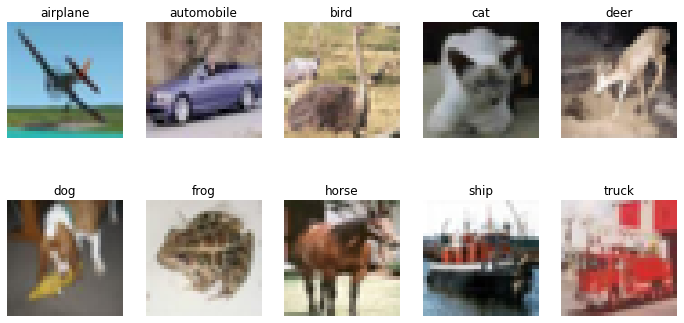

In [5]:
from sklearn.model_selection import train_test_split
(X_train, Y_train),(X_test, Y_test)= tf.keras.datasets.cifar10.load_data()
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
print('Train data shape ' + str(X_train.shape))
print('Train labels shape ' + str(Y_train.shape))
print('Validation data shape ' + str(X_val.shape))
print('Validataion labels shape ' + str(Y_val.shape))
print('Test data shape ' + str(X_test.shape))
print('Test labels shape ' + str(Y_test.shape))

#Normalizing Mean,Std구함
CIFAR10_MEAN = np.mean(X_train.astype(np.float32)/255.0, axis=0)
CIFAR10_STD = np.std(X_train.astype(np.float32)/255.0, axis=0)

#Normalizing수행
X_train = np.array([_preprocess_image(img, CIFAR10_MEAN, CIFAR10_STD) for img in X_train])
X_val   = np.array([_preprocess_image(img, CIFAR10_MEAN, CIFAR10_STD) for img in X_val])
X_test  = np.array([_preprocess_image(img, CIFAR10_MEAN, CIFAR10_STD) for img in X_test])

Class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_images(X_train, Y_train[:,0], Class_names, Each_Category=True)

In [10]:
#Batch 선언 
BATCH_SIZE=500
N_VALIDATION = len(Y_val)
N_TRAIN = len(Y_train)
train_ds= tf.data.Dataset.from_tensor_slices(
    (X_train, Y_train)).cache().shuffle(len(Y_train)).batch(BATCH_SIZE)
val_ds= tf.data.Dataset.from_tensor_slices(
    (X_val, Y_val)).cache().batch(BATCH_SIZE)
test_ds= tf.data.Dataset.from_tensor_slices(
    (X_test, Y_test)).cache().batch(BATCH_SIZE)


## <a name="1"></a> 1. Training a basic CNN model 

In this section, you will learn how to define a simple CNN model architecture, train the model, and evaluate its performance on the validation dataset. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow and configuring a CNN model.

Using the code provided as guidance, **(1) define**, **(2) train**, and **(3) evaluate** a model with the following architecture and training setup:

#### CNN architecture:
* 9x9 Convolutional layer with 8 filters, strides of 1, and ReLU activation
* 3x3 Max pooling layer with strides of 3
* Fully connected layer with 8 output units and ReLU activation
* Fully connected layer with 10 output units and linear activation
* You can use any padding option.

#### Training setup:
* Loss function: Sotfmax cross entropy
* Optimizer: Gradient descent with 0.01 learning rate
* Batch size: 500
* Training epoch: 1

In [7]:
CNN_histories = {}

In [120]:
# Define our model as a class
# It includes our model architecture, loss function, optimizer, and evaluation metrics

class MyCNN(Model) : 
  def __init__(self) : 
    super(MyCNN, self).__init__()
    self.layer1 = tf.keras.layers.Conv2D(5, kernel_size = 3, strides = (1,1), padding='valid', activation = 'relu')
    self.layer2 = tf.keras.layers.Conv2D(5, kernel_size = 3, strides = (1,1), padding='valid', activation = 'relu')
    self.layer3 = tf.keras.layers.Conv2D(5, kernel_size = 3, strides = (1,1), padding='valid', activation = 'relu')
    self.pooling = tf.keras.layers.MaxPool2D(pool_size = (1,1), padding = 'valid')
    self.flatten = tf.keras.layers.Flatten()
    self.out = tf.keras.layers.Dense(10)

  def call(self, input) : 
    #print("input : ",input.shape)
    x = self.layer1(input)
    x = self.pooling(x)
    x = self.layer2(x)
    x = self.pooling(x)
    x = self.layer3(x)
    x = self.flatten(x)
    #print("output : ", x.shape)

    return self.out(x)


simple_model = MyCNN()

# Clear old variables
tf.keras.backend.clear_session()  

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)
optimizer = tf.keras.optimizers.Adam()



In [121]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [122]:
def train_step(images, labels):
  with tf.GradientTape() as tape:
    # training=True is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = simple_model(images, training=True)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, simple_model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, simple_model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [123]:
def test_step(images, labels):
  # training=False is only needed if there are layers with different
  # behavior during training versus inference (e.g. Dropout).
  predictions = simple_model(images, training=False)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [124]:
EPOCHS = 1

for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Accuracy: {train_accuracy.result() * 100}, '
    f'Test Loss: {test_loss.result()}, '
    f'Test Accuracy: {test_accuracy.result() * 100}'
  )

Epoch 1, Loss: 1.9795345067977905, Accuracy: 28.997499465942383, Test Loss: 1.787096619606018, Test Accuracy: 36.88999938964844


## <a name="2"></a>2. Training a CNN model with Inception module 
In this section, you will implement a little more complex CNN model with an `Inception module` [6]. <br>

![Inception_module](/content/drive/My Drive/CNN/Utils/InceptionModule_GoogLeNet.png)

Using the code provided as guidance, <br>
**(1)** Define an `inception module`, which is the building block of **Inception model (a.k.a GoogLeNet)**, the winner of ILSVRC14. <br>
**(2)** Define, train, and evaluate a CNN model with the following architecture and training setup:

#### CNN architecture:
* `Inception module` with 
    * 8 filters for the main convolutions (blue blocks in the Figure(a))
    * 2 filters for the dimensionality reduction convolutions (yellow blocks in the Figure(a))
    *  ReLU activation
* Fully connected layer with 10 output units and linear activation
* Choose the proper padding option on your own.

#### Training setup:
* Loss function: Sotfmax cross entropy
* Optimizer: Gradient descent with 0.01 learning rate
* Batch size: 500
* Training epoch: 5

In [125]:
class Inception_model(Model):
    def __init__(self, C1=8, C3_R=2, C3=8, C5_R=2, C5=8, P3_R=2):
        '''
        C1, C3, C5: number of filters for the main convolutions
        C3_R, C5_R, P3_R: number of filters for the dimensionality reduction convolutions
        '''
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        # Define model architecture
        pass
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################

    def call(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        pass
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################

# Clear old variables
tf.keras.backend.clear_session()

# Declare out simple model
model = Inception_model()   

# Now, train and test the model
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################

##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################

## <a name="3"></a>3. Design a better model on CIFAR-10

Now it's your job to experiment with CNNs to train a model that achieves **<font color=red>>= 70% accuracy on the validation set</font>** of CIFAR-10. <br> You can reuse the implemented functions from above.

### Things you can try to change:
- Filter size
- Number of filters
- Pooling vs Strided Convolution
- Network architectures
- Optimizers
- Activation functions
- Regularizations
- Model ensembles
- Data augmentation

In [126]:
class my_model(object):
    def __init__(self):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        # Define model architecture
        pass
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################
    def call(self, x):
        ##############################################################################
        #                          IMPLEMENT YOUR CODE                               #
        ##############################################################################
        # Train and eval. Pleas print the loss and accuracy in training and evaluation.
        pass
        ##############################################################################
        #                             END OF YOUR CODE                               #
        ##############################################################################

# Clear old variables
tf.keras.backend.clear_session()

# Declare out simple model
model = my_model()   
# Now, train and test the model
##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################

##############################################################################
#                          IMPLEMENT YOUR CODE                               #
##############################################################################